# Compositional Contextual Expert Bandits [CCEB]

## Part 1: Defining The Inference System

In [1]:
import torch
import numpy as np
# Set so that each particle will only use one thread
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
# set torch print options, including line width
torch.set_printoptions(precision=4, sci_mode=False, linewidth=250)

import torch.distributions as D
import matplotlib.pyplot as plt
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor

In [2]:
from ensemble import Ensemble
from particle import print_particle_params, Particle
from utils_categorical import cat_sample

/scratch/Cloud/Projects/_Contextual_Inference/ParticleFilters/.venvVN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Defining the experiment

### Define the various contexts that can be encountered

In [3]:
NOISE = 0.02

dist_c_0_s_0 = D.MultivariateNormal(loc=torch.tensor([1.0, 0.0, 0.0]), covariance_matrix=torch.eye(3)*NOISE)
dist_c_0_s_1 = D.MultivariateNormal(loc=torch.tensor([-1.0, 0.0, 0.0]), covariance_matrix=torch.eye(3)*NOISE)

dist_c_1_s_0 = D.MultivariateNormal(loc=torch.tensor([0.0, 1.0, 0.0]), covariance_matrix=torch.eye(3)*NOISE)
dist_c_1_s_1 = D.MultivariateNormal(loc=torch.tensor([0.0, -1.0, 0.0]), covariance_matrix=torch.eye(3)*NOISE)

dist_c_2_s_0 = D.MultivariateNormal(loc=torch.tensor([0.0, 0.0, 1.0]), covariance_matrix=torch.eye(3)*NOISE)
dist_c_2_s_1 = D.MultivariateNormal(loc=torch.tensor([0.0, 0.0, -1.0]), covariance_matrix=torch.eye(3)*NOISE)

def generate_observation(true_c_o, true_s):
    """
    Three possible observation contexts
    """
    if true_c_o == 0:
        if true_s == 0:
            return dist_c_0_s_0.sample()
        else:
            return dist_c_0_s_1.sample()
    elif true_c_o == 1:
        if true_s == 0:
            return dist_c_1_s_0.sample()
        else:
            return dist_c_1_s_1.sample()
    elif true_c_o == 2:
        if true_s == 0:
            return dist_c_2_s_0.sample()
        else:
            return dist_c_2_s_1.sample()
    else:
        raise ValueError("true_c must be 0, 1, or 2")


def generate_reward(true_s, a_t, true_c_r):
    """
    Two possible reward contexts
    """
    
    if true_c_r == 0:
        if true_s == 0:
            return 1.0 if a_t == 0 else 0.0
        else:
            return 1.0 if a_t == 1 else 0.0
    elif true_c_r == 1:
        if true_s == 0:
            return 1.0 if a_t == 2 else 0.0
        else:
            return 1.0 if a_t == 3 else 0.0
    else:
        raise ValueError("true_s must be 0 or 1")

#### Definte a series of trials in the same context

In [4]:
# Initialize history buffers
context_o_hist = []
context_r_hist = []
actions_hist = []
jumps_hist = []
true_rewarding_actions = []


def batched_trials(ensemble: Ensemble, true_c_o_t, true_c_r_t, n_steps=50):
    """
    Run a batch of trials with the given context combination.
    """

    print(f"\n << Running {n_steps} trials with true_c_o_t={true_c_o_t}, true_c_r_t={true_c_r_t} >> \n")

    for i in range(n_steps):
        print(f"Step {i+1}:")

        # Sample state and observation
        true_s_t = cat_sample(torch.tensor([0.5, 0.5]))
        o_t = generate_observation(true_c_o_t, true_s_t)
        
        print(f"\tTrue state: {true_s_t}, Observation: {np.array2string(o_t.numpy(), formatter={'float_kind':lambda x: f'{x: .1f}'})}")
        
        # Process observation
        ensemble.before_action(o_t)    
        
        # Select action
        a_t, actions = ensemble.select_action()
        
        # Generate reward
        r_t = generate_reward(true_s_t, a_t, true_c_r_t)

        # count proportion of particles selecting each action
        action_counts = np.bincount(actions.numpy(), minlength=4)
        action_proportions = action_counts / ensemble.N
        action_proportions = np.array2string(action_proportions, formatter={'float_kind':lambda x: f"{x: .2f}"})
        print(f"\tAction proportions: {action_proportions}, Selected action: {a_t}, Reward: {r_t}")

        # Update model
        ensemble.after_action(a_t, r_t)
        
        # Record keeping
        context_o_hist.append(ensemble.vec_c_o_t.clone().detach().numpy())
        jumps_hist.append(ensemble.vec_j_t.clone().detach().numpy())
        actions_hist.append(actions.clone().detach().numpy())
        if true_c_r_t == 0:
            true_rewarding_actions.append(0 if true_s_t == 0 else 1)
        elif true_c_r_t == 1:
            true_rewarding_actions.append(2 if true_s_t == 0 else 3)
        context_r_hist.append(ensemble.vec_c_r_t.clone().detach().numpy())

## Part 2: Run Simulation

#### Simulation

In [5]:
# Initialize ensemble
ensemble = Ensemble(N=250, hyp_gamma=0.1, hyp_alpha_o=0.2, hyp_alpha_r=0.1)

# Run 50 trials in context (c_o=0, c_r=0)
batched_trials(ensemble, true_c_o_t=0, true_c_r_t=0, n_steps=50)


# Run 50 trials in context (c_o=1, c_r=0)
batched_trials(ensemble, true_c_o_t=1, true_c_r_t=0, n_steps=50)

# Run 10 trials in the first context again
batched_trials(ensemble, true_c_o_t=0, true_c_r_t=0, n_steps=10)


# Run 50 trials in context (c_o=2, c_r=1)
batched_trials(ensemble, true_c_o_t=2, true_c_r_t=1, n_steps=50)

# Run 10 trials in the first context again
batched_trials(ensemble, true_c_o_t=0, true_c_r_t=0, n_steps=10)
# Run 10 trials in the second context again
batched_trials(ensemble, true_c_o_t=1, true_c_r_t=0, n_steps=10)


# Run 50 trials in context (c_o=0, c_r=1)
batched_trials(ensemble, true_c_o_t=0, true_c_r_t=1, n_steps=50)

# Run 10 trials in the first context again
batched_trials(ensemble, true_c_o_t=0, true_c_r_t=0, n_steps=10)
# Run 10 trials in the second context again
batched_trials(ensemble, true_c_o_t=1, true_c_r_t=0, n_steps=10)
# Run 10 trials in the third context again
batched_trials(ensemble, true_c_o_t=2, true_c_r_t=1, n_steps=10)


 << Running 50 trials with true_c_o_t=0, true_c_r_t=0 >> 

Step 1:
	True state: 1, Observation: [-0.7  0.0  0.1]
	Action proportions: [ 0.26  0.25  0.19  0.30], Selected action: 1, Reward: 1.0
Step 2:
	True state: 1, Observation: [-1.0 -0.1 -0.4]
	Action proportions: [ 0.06  0.78  0.06  0.09], Selected action: 1, Reward: 1.0
Step 3:
	True state: 0, Observation: [ 0.9 -0.0 -0.1]
	Action proportions: [ 0.11  0.66  0.10  0.13], Selected action: 3, Reward: 0.0
Step 4:
	True state: 0, Observation: [ 1.1  0.2 -0.1]
	Action proportions: [ 0.13  0.58  0.24  0.04], Selected action: 1, Reward: 0.0
Step 5:
	True state: 1, Observation: [-1.0 -0.0  0.1]
	Action proportions: [ 0.02  0.89  0.05  0.04], Selected action: 3, Reward: 0.0
Step 6:
	True state: 0, Observation: [ 1.0 -0.1  0.1]
	Action proportions: [ 0.26  0.06  0.64  0.04], Selected action: 2, Reward: 0.0
Step 7:
	True state: 1, Observation: [-0.8 -0.1  0.1]
	Action proportions: [ 0.05  0.91  0.03  0.01], Selected action: 1, Reward: 1.0
St

## Part 3: Analysis of Results

#### Sanity check of inferred parameters

In [6]:
for particle in ensemble.particles:
    print(f"\n>> Particle {particle}:\n")
    print_particle_params(particle)
    


>> Particle <particle.Particle object at 0x7aec17926c60>:

> Observation Models:
State 0, Observ Context 0, Observation Model Params: df: 57.0, loc: [ 1.01 -0.01 -0.00]
State 0, Observ Context 1, Observation Model Params: df: 34.0, loc: [ 0.02  1.00  0.01]
State 0, Observ Context 2, Observation Model Params: df: 32.0, loc: [-0.01 -0.00  1.00]
State 1, Observ Context 0, Observation Model Params: df: 77.0, loc: [-0.97  0.01 -0.01]
State 1, Observ Context 1, Observation Model Params: df: 40.0, loc: [ 0.01 -1.02 -0.00]
State 1, Observ Context 2, Observation Model Params: df: 32.0, loc: [-0.00 -0.00 -0.98]

Obser. Context CRP Probabilities: [ 0.62  0.25  0.12  0.01] Suff Stats: [10.  4.  2.]

> Reward Models:
State 0, Reward Context 0, Reward Model Mean: [ 1.00  0.00  0.00  0.00], Suff Stats: [67.1  0.1  0.1  0.1]
State 0, Reward Context 1, Reward Model Mean: [ 0.00  0.00  0.99  0.00], Suff Stats: [ 0.1  0.1 50.1  0.1]
State 1, Reward Context 0, Reward Model Mean: [ 0.00  1.00  0.00  0.00]

### Visualisation of Results

Context O History:


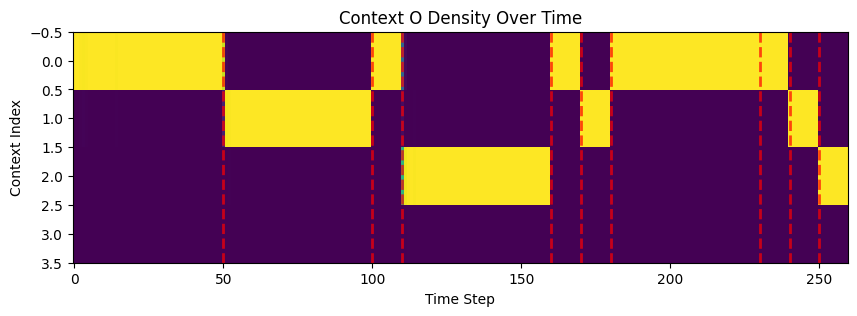

Context R History:


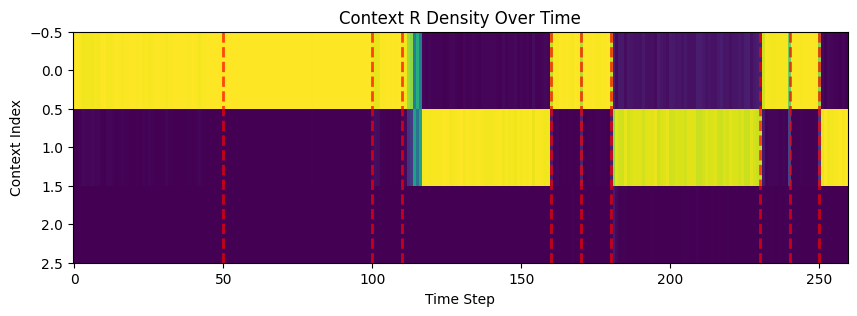

Actions History:


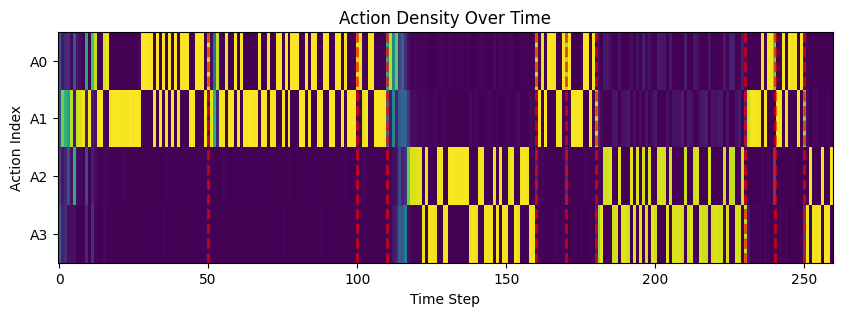

Proportion of Optimal Actions Over Time:


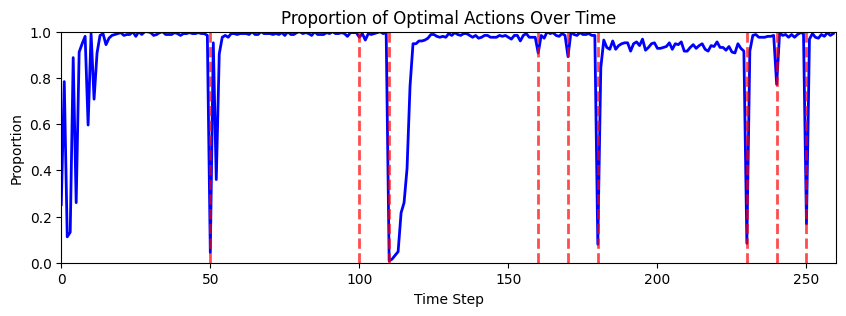

Jump History:


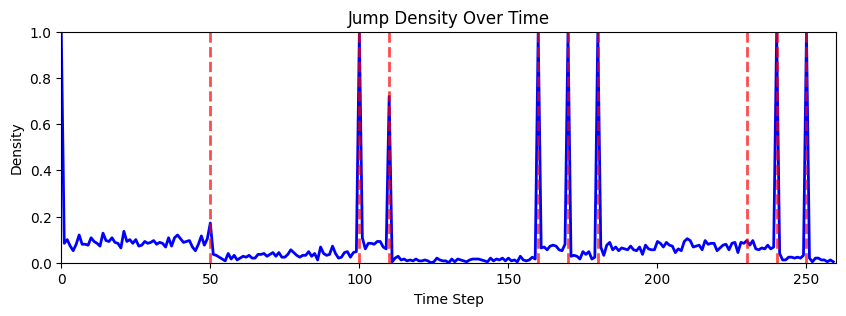

In [9]:
jump_times = [50, 100, 110, 160, 170, 180, 230, 240, 250]
context_o_hist_arr = np.array(context_o_hist)
context_r_hist_arr = np.array(context_r_hist)
actions_hist_arr = np.array(actions_hist)
jumps_hist_arr = np.array(jumps_hist)


print("Context O History:")
max_context_o = np.max(context_o_hist_arr) + 1
context_o_densities = np.zeros((len(context_o_hist_arr), max_context_o))
for idx, element in enumerate(context_o_hist_arr):
    for val in element:
        context_o_densities[idx, val] += 1
context_o_densities = context_o_densities / context_o_densities.sum(axis=1, keepdims=True)

# set size of plot
plt.figure(figsize=(10, 3))
plt.imshow(context_o_densities.T, aspect='auto', cmap='viridis', interpolation='nearest')
#plt.colorbar(label='Density')
for jt in jump_times:
    plt.axvline(x=jt, color='red', linestyle='--', linewidth=2, alpha=0.7)


plt.xlabel('Time Step')
plt.ylabel('Context Index')
plt.title('Context O Density Over Time')
plt.show()

print("Context R History:")
max_context_r = np.max(context_r_hist_arr) + 1
context_r_densities = np.zeros((len(context_r_hist_arr), max_context_r))
for idx, element in enumerate(context_r_hist_arr):
    for val in element:
        context_r_densities[idx, val] += 1
context_r_densities = context_r_densities / context_r_densities.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 3))
plt.imshow(context_r_densities.T, aspect='auto', cmap='viridis', interpolation='nearest')
#plt.colorbar(label='Density')
for jt in jump_times:
    plt.axvline(x=jt, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Context Index')
plt.title('Context R Density Over Time')
plt.show()

print("Actions History:")
actions_densities = np.zeros((len(actions_hist), 4))
for idx, element in enumerate(actions_hist):
    #print(element)
    for val in element:
        actions_densities[idx, val] += 1
actions_densities = actions_densities / actions_densities.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 3))
plt.imshow(actions_densities.T, aspect='auto', cmap='viridis', interpolation='nearest')
#plt.colorbar(label='Density')
plt.yticks(ticks=[0, 1, 2, 3], labels=['A0', 'A1', 'A2', 'A3'])
for jt in jump_times:
    plt.axvline(x=jt, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Action Index')
plt.title('Action Density Over Time')
plt.show()

print("Proportion of Optimal Actions Over Time:")
true_rewarding_actions = np.array(true_rewarding_actions)
proportion_optimal = np.zeros(len(actions_hist))
for idx, element in enumerate(actions_hist):
    proportion_optimal[idx] = np.sum(element == true_rewarding_actions[idx]) / len(element)
plt.figure(figsize=(10, 3))
plt.plot(proportion_optimal, label='Proportion Optimal Action', color='blue', linewidth=2)
plt.title('Proportion of Optimal Actions Over Time')
plt.xlabel('Time Step')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.xlim(0, len(proportion_optimal))
for jt in jump_times:
    plt.axvline(x=jt, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.show()

print("Jump History:")
jumps_densities = np.zeros(len(jumps_hist))
for idx, element in enumerate(jumps_hist):
    jumps_densities[idx] = np.sum(element) / ensemble.N

plt.figure(figsize=(10, 3))
plt.plot(jumps_densities, label='Jump', color='blue', linewidth=2)
plt.title('Jump Density Over Time')
plt.xlabel('Time Step')
plt.ylabel('Density')
plt.ylim(0, 1)
plt.xlim(0, len(jumps_densities))
for jt in jump_times:
    plt.axvline(x=jt, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.show()
